In [ ]:
!pip install keras-tuner
!pip install tensorflow
!pip install scikeras

import keras_tuner as kt

import pandas as pd
import numpy as np
import random

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.utils import plot_model

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler,StandardScaler,OneHotEncoder,OrdinalEncoder

SEED_VALUE=123
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


In [ ]:
df = pd.read_csv('dataset.csv')
df.head()

,Month,Hour,DayOfWeek,Holiday,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,EnergyConsumption
0,8,3,Sunday,Yes,24.492063,59.969085,1403.454805,7,On,Off,29.965327,82.057358
1,1,8,Wednesday,No,26.312114,51.408711,1220.547133,8,On,Off,5.986875,83.889177
2,1,19,Sunday,Yes,20.516186,40.918500,1114.230124,8,Off,On,20.489098,66.202098
3,7,3,Wednesday,Yes,20.879426,46.859237,1096.207227,7,Off,On,21.321157,66.439179
4,10,17,Saturday,No,23.015216,48.998158,1999.982252,1,Off,Off,3.966075,76.902272


# EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Month              1232 non-null   object 
 1   Hour               1232 non-null   int64  
 2   DayOfWeek          1232 non-null   object 
 3   Holiday            1232 non-null   object 
 4   Temperature        1232 non-null   float64
 5   Humidity           1232 non-null   float64
 6   SquareFootage      1232 non-null   float64
 7   Occupancy          1232 non-null   int64  
 8   HVACUsage          1232 non-null   object 
 9   LightingUsage      1232 non-null   object 
 10  RenewableEnergy    1232 non-null   float64
 11  EnergyConsumption  1229 non-null   float64
dtypes: float64(5), int64(2), object(5)
memory usage: 115.6+ KB


In [ ]:
df.isna().sum()


,0
Month,0
Hour,0
DayOfWeek,0
Holiday,0
Temperature,0
Humidity,0
SquareFootage,0
Occupancy,0
HVACUsage,0
LightingUsage,0


From the information above, there is only one coloumn that has null values, which is EnergyConsumption, our target variable. Since the missing values come from the target variable, and there's only 3 rows with missing values, we will drop these rows

In [ ]:
df=df.dropna()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1229 entries, 0 to 1231
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Month              1229 non-null   object 
 1   Hour               1229 non-null   int64  
 2   DayOfWeek          1229 non-null   object 
 3   Holiday            1229 non-null   object 
 4   Temperature        1229 non-null   float64
 5   Humidity           1229 non-null   float64
 6   SquareFootage      1229 non-null   float64
 7   Occupancy          1229 non-null   int64  
 8   HVACUsage          1229 non-null   object 
 9   LightingUsage      1229 non-null   object 
 10  RenewableEnergy    1229 non-null   float64
 11  EnergyConsumption  1229 non-null   float64
dtypes: float64(5), int64(2), object(5)
memory usage: 124.8+ KB


Successfully dropped null rows

In [ ]:
df.head()

,Month,Hour,DayOfWeek,Holiday,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,EnergyConsumption
0,8,3,Sunday,Yes,24.492063,59.969085,1403.454805,7,On,Off,29.965327,82.057358
1,1,8,Wednesday,No,26.312114,51.408711,1220.547133,8,On,Off,5.986875,83.889177
2,1,19,Sunday,Yes,20.516186,40.918500,1114.230124,8,Off,On,20.489098,66.202098
3,7,3,Wednesday,Yes,20.879426,46.859237,1096.207227,7,Off,On,21.321157,66.439179
4,10,17,Saturday,No,23.015216,48.998158,1999.982252,1,Off,Off,3.966075,76.902272


In [ ]:
df.duplicated().sum()

np.int64(0)

No duplicate entries

Next we check each columns for any anomalous entries, that mightve gone unnoticed from the preview of the dataset

In [ ]:
for col in df.columns:
    print(f"Value counts for '{col}':")
    print(df[col].value_counts())
    print()

Value counts for 'Month':
Month
1            189
4            119
10           115
3             99
12            99
6             95
11            92
8             89
7             88
5             84
9             83
2             64
Sep            7
July           4
September      2
Name: count, dtype: int64

Value counts for 'Hour':
Hour
14    63
0     62
10    58
3     57
2     56
4     56
17    56
6     55
5     54
18    54
19    52
9     51
13    51
21    51
1     48
15    48
11    48
8     46
23    45
20    45
22    45
12    45
7     42
16    41
Name: count, dtype: int64

Value counts for 'DayOfWeek':
DayOfWeek
Sunday       192
Saturday     183
Thursday     182
Friday       169
Tuesday      168
Monday       168
Wednesday    167
Name: count, dtype: int64

Value counts for 'Holiday':
Holiday
No     673
Yes    556
Name: count, dtype: int64

Value counts for 'Temperature':
Temperature
29.998671    73
20.007565    66
28.116093     1
26.423330     1
28.362274     1
             ..
27

In column Month, some months are in text or abbreviated form, we will replace these months with their corresponding month number

In column Occupancy, theres one entry with Occupancy = '-5', which shouldnt be possible. Since its only 1 row, we will drop this row, to prevent making assumptions



In [ ]:
df = df[df['Occupancy'] != -5]

In [ ]:
print(df['Occupancy'].value_counts())

Occupancy
7    144
9    142
6    138
0    130
3    129
2    128
4    114
8    105
5    105
1     93
Name: count, dtype: int64


Successfully removed the row of occupancy with -5

Here ill split the columnns of the dataset to numerical and categorical columns, just for convenience sake

In [ ]:
num_cols = []
cat_cols = []

for i in df.columns:
    if df[i].dtype == 'object':
        cat_cols.append(i)
    elif "int" in str(df[i].dtype) or "float" in str(df[i].dtype):
        num_cols.append(i)

print(num_cols)
print(cat_cols)

['Hour', 'Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'RenewableEnergy', 'EnergyConsumption']
['Month', 'DayOfWeek', 'Holiday', 'HVACUsage', 'LightingUsage']


We'll first fix the anomalous data within Month

In [ ]:
df['Month'] = df['Month'].replace('Sep', '9')
df['Month'] = df['Month'].replace('July', '7')
df['Month'] = df['Month'].replace('September', '9')

In [ ]:
print(df['Month'].value_counts())


Month
1     189
4     119
10    114
3      99
12     99
6      95
9      92
7      92
11     92
8      89
5      84
2      64
Name: count, dtype: int64


Successfully replaced anomalous data with their actual data and datatype

# Data Splitting

In [ ]:
x=df.drop('EnergyConsumption',axis=1)
y=df['EnergyConsumption']

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)

x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.66, random_state=42)

print(x_train.shape,y_train.shape)
print(x_val.shape,y_val.shape)
print(x_test.shape,y_test.shape)

(859, 11) (859,)
(125, 11) (125,)
(244, 11) (244,)


With a total a total of 1228 rowws

train = 859*100/1228 = ~70%

val = 125*100/1228 = ~10%

train = 244*100/1228 = ~20%

# Feature Encoding

We will use OHE for nominal columns (DayOfWeek and Month). We treat month and day of week as nominal, because they do not have any inherent order, so each month is treated equally

we will encode binary columns as 0,1 ('Holiday', 'HVACUsage', 'LightingUsage')

and in our case, there arent any ordinal columns, so ordinal encoder is not required

In [ ]:
ohe_encoder = OneHotEncoder(sparse_output=False,handle_unknown='ignore')
encoded = ohe_encoder.fit_transform(x_train[['DayOfWeek']])
encoded_df = pd.DataFrame(encoded, columns=ohe_encoder.get_feature_names_out(['DayOfWeek']))
x_train = x_train.reset_index(drop=True)
x_train = pd.concat([x_train.drop('DayOfWeek',axis=1,errors='ignore'), encoded_df], axis=1)

encoded = ohe_encoder.fit_transform(x_val[['DayOfWeek']])
encoded_df = pd.DataFrame(encoded, columns=ohe_encoder.get_feature_names_out(['DayOfWeek']))
x_val = x_val.reset_index(drop=True)
x_val = pd.concat([x_val.drop('DayOfWeek',axis=1,errors='ignore'), encoded_df], axis=1)

encoded = ohe_encoder.fit_transform(x_test[['DayOfWeek']])
encoded_df = pd.DataFrame(encoded, columns=ohe_encoder.get_feature_names_out(['DayOfWeek']))
x_test = x_test.reset_index(drop=True)
x_test = pd.concat([x_test.drop('DayOfWeek',axis=1,errors='ignore'), encoded_df], axis=1)

In [ ]:
x_train.head()

,Month,Hour,Holiday,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday
0,1,19,Yes,20.516186,40.918500,1114.230124,8,Off,On,20.489098,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2,9,Yes,22.264567,40.735752,1315.024311,1,Off,Off,20.540906,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,8,15,No,28.430206,48.410391,1358.395838,7,On,Off,3.269959,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,11,10,Yes,25.549966,41.084961,1000.512661,6,Off,Off,0.006642,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,7,15,Yes,24.889613,34.873881,1999.982252,0,On,On,24.983800,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
x_train.tail()

,Month,Hour,Holiday,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday
854,11,18,No,27.676510,46.394307,1793.996762,5,Off,On,18.924240,0.0,0.0,1.0,0.0,0.0,0.0,0.0
855,1,11,Yes,27.425114,32.394788,1155.230100,9,On,Off,8.166147,0.0,0.0,0.0,1.0,0.0,0.0,0.0
856,5,2,No,20.066522,45.900996,1283.081511,5,Off,On,27.827577,0.0,0.0,0.0,0.0,0.0,1.0,0.0
857,5,11,No,20.007565,59.969085,1073.104210,1,Off,Off,0.006642,0.0,0.0,0.0,0.0,0.0,0.0,1.0
858,3,8,Yes,29.998671,59.555537,1758.094136,3,On,Off,19.281681,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
x_val.tail()

,Month,Hour,Holiday,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday
120,12,20,No,26.986393,55.746345,1563.124408,1,Off,On,27.659718,1.0,0.0,0.0,0.0,0.0,0.0,0.0
121,12,12,Yes,22.266377,49.663774,1365.837604,4,Off,Off,6.069762,0.0,0.0,1.0,0.0,0.0,0.0,0.0
122,3,19,Yes,23.307098,39.857505,1348.509256,1,Off,Off,0.006642,0.0,0.0,0.0,1.0,0.0,0.0,0.0
123,6,6,Yes,26.455075,31.118752,1383.198667,8,On,Off,26.159759,1.0,0.0,0.0,0.0,0.0,0.0,0.0
124,10,11,Yes,21.238575,35.859894,1000.512661,7,On,On,27.218234,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
x_test.tail()

,Month,Hour,Holiday,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday
239,6,9,No,26.105661,55.820823,1304.459676,0,Off,Off,25.098156,0.0,0.0,0.0,1.0,0.0,0.0,0.0
240,2,12,Yes,22.338108,52.796287,1935.580917,5,Off,Off,18.683754,0.0,0.0,0.0,0.0,0.0,0.0,1.0
241,6,14,Yes,27.338689,56.350301,1343.724359,9,Off,Off,28.160596,0.0,0.0,0.0,1.0,0.0,0.0,0.0
242,3,3,No,21.515827,50.175738,1353.199834,6,Off,On,1.945996,0.0,0.0,0.0,0.0,0.0,0.0,1.0
243,7,4,No,29.876927,33.525081,1344.741490,5,On,Off,7.058110,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
ohe_encoder = OneHotEncoder(sparse_output=False,handle_unknown='ignore')
encoded = ohe_encoder.fit_transform(x_train[['Month']])
encoded_df = pd.DataFrame(encoded, columns=ohe_encoder.get_feature_names_out(['Month']))
x_train = x_train.reset_index(drop=True)
x_train = pd.concat([x_train.drop('Month',axis=1,errors='ignore'), encoded_df], axis=1)

encoded = ohe_encoder.fit_transform(x_val[['Month']])
encoded_df = pd.DataFrame(encoded, columns=ohe_encoder.get_feature_names_out(['Month']))
x_val = x_val.reset_index(drop=True)
x_val = pd.concat([x_val.drop('Month',axis=1,errors='ignore'), encoded_df], axis=1)

encoded = ohe_encoder.fit_transform(x_test[['Month']])
encoded_df = pd.DataFrame(encoded, columns=ohe_encoder.get_feature_names_out(['Month']))
x_test = x_test.reset_index(drop=True)
x_test = pd.concat([x_test.drop('Month',axis=1,errors='ignore'), encoded_df], axis=1)

In [ ]:
x_train.head()

,Hour,Holiday,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek_Friday,...,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9
0,19,Yes,20.516186,40.918500,1114.230124,8,Off,On,20.489098,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9,Yes,22.264567,40.735752,1315.024311,1,Off,Off,20.540906,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,15,No,28.430206,48.410391,1358.395838,7,On,Off,3.269959,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,10,Yes,25.549966,41.084961,1000.512661,6,Off,Off,0.006642,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,15,Yes,24.889613,34.873881,1999.982252,0,On,On,24.983800,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Each subset of our split df has been successfully encoded for column DayOfWeek

Next we will encode our binary columns

In [ ]:
binary_cols = x_train[['Holiday','HVACUsage','LightingUsage']]

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

for columns in binary_cols:
  x_train[columns] = label_encoder.fit_transform(x_train[columns])
  x_val[columns] = label_encoder.fit_transform(x_val[columns])
  x_test[columns] = label_encoder.fit_transform(x_test[columns])



In [ ]:
x_train.head()

,Hour,Holiday,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek_Friday,...,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9
0,19,1,20.516186,40.918500,1114.230124,8,0,1,20.489098,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9,1,22.264567,40.735752,1315.024311,1,0,0,20.540906,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,15,0,28.430206,48.410391,1358.395838,7,1,0,3.269959,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,10,1,25.549966,41.084961,1000.512661,6,0,0,0.006642,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,15,1,24.889613,34.873881,1999.982252,0,1,1,24.983800,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


We've successfully encoded our binary columns, mapping Yes to 1 and No to 0

In [ ]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 859 entries, 0 to 858
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Hour                 859 non-null    int64  
 1   Holiday              859 non-null    int64  
 2   Temperature          859 non-null    float64
 3   Humidity             859 non-null    float64
 4   SquareFootage        859 non-null    float64
 5   Occupancy            859 non-null    int64  
 6   HVACUsage            859 non-null    int64  
 7   LightingUsage        859 non-null    int64  
 8   RenewableEnergy      859 non-null    float64
 9   DayOfWeek_Friday     859 non-null    float64
 10  DayOfWeek_Monday     859 non-null    float64
 11  DayOfWeek_Saturday   859 non-null    float64
 12  DayOfWeek_Sunday     859 non-null    float64
 13  DayOfWeek_Thursday   859 non-null    float64
 14  DayOfWeek_Tuesday    859 non-null    float64
 15  DayOfWeek_Wednesday  859 non-null    flo

# Scaling

Next, we're going to scale our numerical variables in order to standardize their ranges. This will prevent our model from thinking a certain variable has greater influence given a larger range

In [ ]:
num_cols.remove('EnergyConsumption')

In [ ]:
num_cols

['Hour',
 'Temperature',
 'Humidity',
 'SquareFootage',
 'Occupancy',
 'RenewableEnergy']

In order to choose the appropriate scaler for each columns, we'll take a look at their distribution

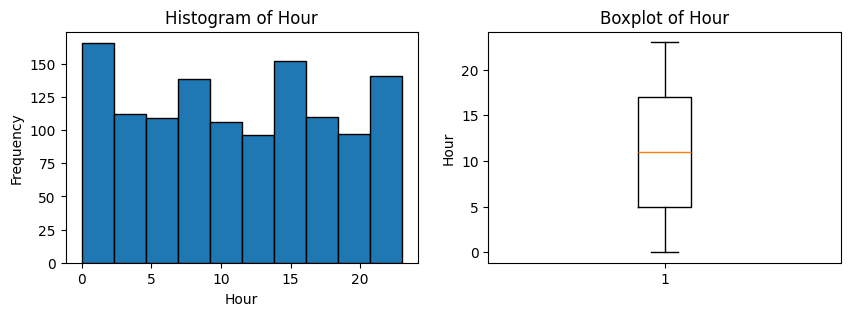

Skewness of Hour: 0.029169649459106533
Kurtosis of Hour: -1.2144244656020857


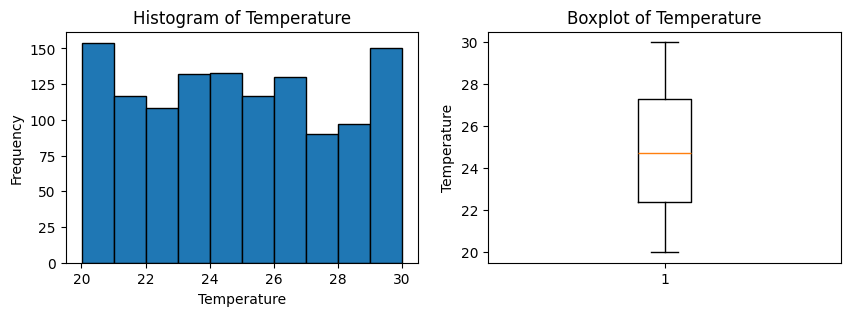

Skewness of Temperature: 0.0776373721206458
Kurtosis of Temperature: -1.1127675243864208


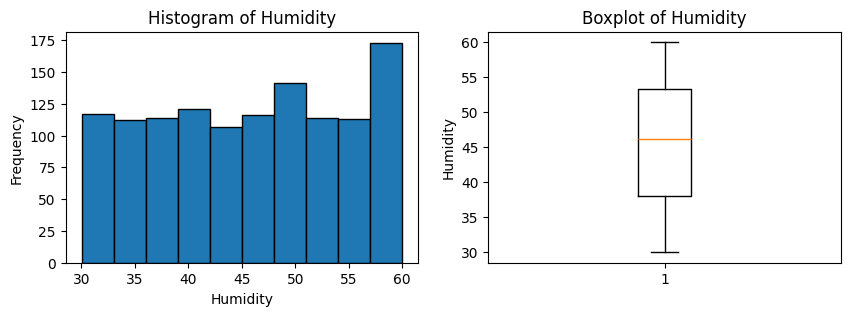

Skewness of Humidity: -0.0716965388571922
Kurtosis of Humidity: -1.1488598151639784


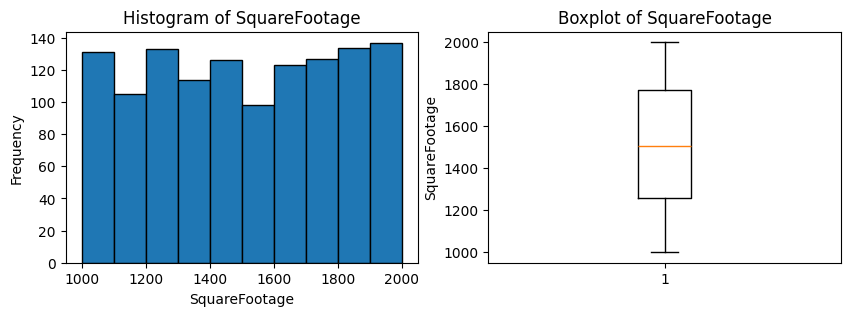

Skewness of SquareFootage: -0.03304132599645419
Kurtosis of SquareFootage: -1.2066642620735768


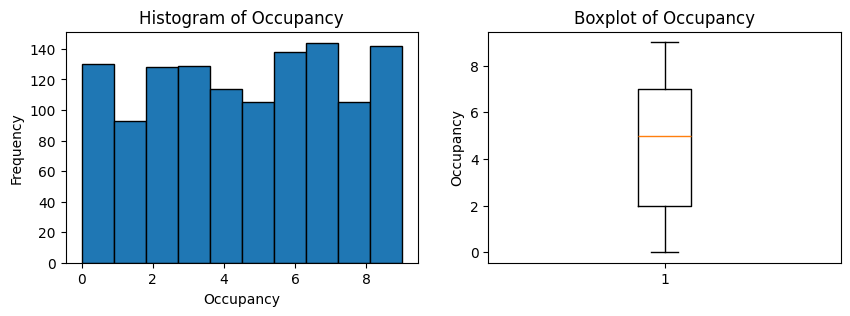

Skewness of Occupancy: -0.059093911221706694
Kurtosis of Occupancy: -1.2169449855650338


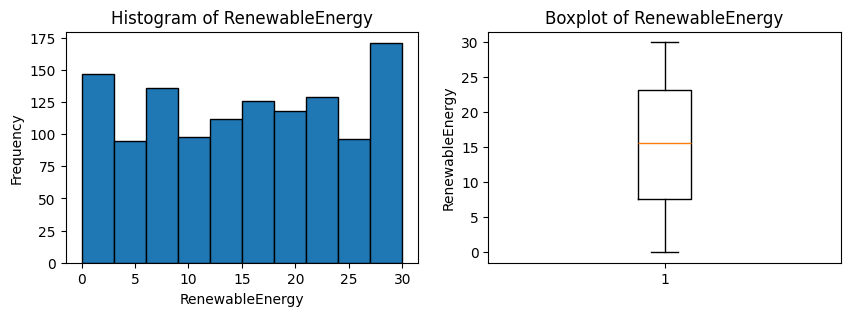

Skewness of RenewableEnergy: -0.04622614705118566
Kurtosis of RenewableEnergy: -1.1673890972329062


In [ ]:
def dist(df, num_cols):
    for col in num_cols:
        plt.figure(figsize=(10, 3))

        # Histogram
        plt.subplot(1, 2, 1)
        plt.hist(df[col], edgecolor='black')
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')

        # Boxplot
        plt.subplot(1, 2, 2)
        plt.boxplot(df[col])
        plt.title(f'Boxplot of {col}')
        plt.ylabel(col)

        plt.show()

        # Calculate and print skewness and kurtosis
        skewness = df[col].skew()
        kurtosis = df[col].kurt()
        print(f'Skewness of {col}: {skewness}')
        print(f'Kurtosis of {col}: {kurtosis}')

dist(df,num_cols)

Due to the absence of outliers in all our numerical columns, we do not have to use RobustScaler.

Furthermore, the skewness values for each graph are rather small, indicating even tails on each ends of the graph

due to these factors, we will use StandardScaler as our scaling method for columns which do not have a reasonable range of values

*standard scaler is also a safer option, as we dont have prior knowledge on the min and max ranges or scales of each column, preventing us from using minmaxscaler

The only exception is hour, where we know the bounds of hour (0-23), temperature and humidity, because both these 3 variables have known upper bounds, and can barely exceed these bounds. (weather temperature and humidity can only get so high)

In [ ]:
from sklearn.preprocessing import StandardScaler

standardscale_cols = ['Occupancy', 'RenewableEnergy', 'SquareFootage',
                      ]

scaler = StandardScaler()
x_train[standardscale_cols] = scaler.fit_transform(x_train[standardscale_cols])
x_val[standardscale_cols] = scaler.transform(x_val[standardscale_cols])
x_test[standardscale_cols] = scaler.transform(x_test[standardscale_cols])

x_train.head()

,Hour,Holiday,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek_Friday,...,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9
0,19,1,20.516186,40.918500,-1.354355,1.194108,0,1,0.549026,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9,1,22.264567,40.735752,-0.667788,-1.221831,0,0,0.554712,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,15,0,28.430206,48.410391,-0.519490,0.848974,1,0,-1.340662,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,10,1,25.549966,41.084961,-1.743185,0.503840,0,0,-1.698790,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,15,1,24.889613,34.873881,1.674259,-1.566965,1,1,1.042291,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()

standardscale_cols = ['Hour', 'Humidity', 'Temperature']

x_train[standardscale_cols] = scaler.fit_transform(x_train[standardscale_cols])
x_val[standardscale_cols] = scaler.transform(x_val[standardscale_cols])
x_test[standardscale_cols] = scaler.transform(x_test[standardscale_cols])

x_train.head()

,Hour,Holiday,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek_Friday,...,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9
0,0.826087,1,0.050907,0.363986,-1.354355,1.194108,0,1,0.549026,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.391304,1,0.225901,0.357885,-0.667788,-1.221831,0,0,0.554712,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.652174,0,0.843014,0.614107,-0.519490,0.848974,1,0,-1.340662,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.434783,1,0.554734,0.369544,-1.743185,0.503840,0,0,-1.698790,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.652174,1,0.488639,0.162184,1.674259,-1.566965,1,1,1.042291,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


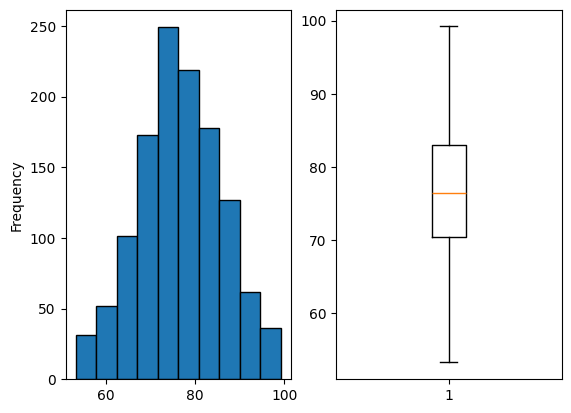

In [ ]:
 # Histogram
plt.subplot(1, 2, 1)
plt.hist(df['EnergyConsumption'], edgecolor='black')
plt.ylabel('Frequency')

        # Boxplot
plt.subplot(1, 2, 2)
plt.boxplot(df['EnergyConsumption'])

plt.show()

Next we're going to scale our target variable. Due to the absence of outliers and the distribution following a normal distribution, we will use standardscaler


In [ ]:
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(pd.DataFrame(y_train))
y_val = scaler_y.transform(pd.DataFrame(y_val))
y_test = scaler_y.transform(pd.DataFrame(y_test))

y_train

array([[-1.10413689],
       [-0.90944529],
       [-0.61392171],
       [-0.57961952],
       [ 0.32931569],
       [-1.34827247],
       [-0.77764359],
       [ 1.64821768],
       [-0.44995387],
       [-0.3506409 ],
       [ 0.47361651],
       [-0.3830409 ],
       [-0.29802629],
       [ 0.76734021],
       [ 0.59069082],
       [ 1.85857863],
       [ 1.53213898],
       [-1.38579003],
       [ 0.28011573],
       [ 1.29041193],
       [-1.36406944],
       [-1.09730982],
       [-1.62092873],
       [-0.64579967],
       [-0.52718498],
       [-0.95690007],
       [ 0.57993623],
       [ 0.03536514],
       [ 0.08336853],
       [ 1.49413611],
       [-0.51351441],
       [ 0.06635189],
       [ 0.41251501],
       [-1.79108208],
       [-0.95625949],
       [ 0.21043509],
       [-0.21514179],
       [ 2.33903233],
       [ 0.84454798],
       [-0.99075391],
       [ 0.2592669 ],
       [-0.89998713],
       [ 0.11425883],
       [-1.61488331],
       [-0.41537019],
       [ 0

# Modelling

First we're going to build our tensor datasets by btaching each of our split dataset.

initially i will start with 32 samples per batch

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(32).shuffle(10)
test_ds = tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(32)
val_ds = tf.data.Dataset.from_tensor_slices((x_val,y_val)).batch(32)

In [ ]:
train_ds

<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 28), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

## Sequential

I'll first build a simple sequential model, with 56 neurons per layer and a total of 2 hidden layers and 1 output layer

In [ ]:
modelSeq = tf.keras.Sequential(
    [
        Dense(56, activation="relu",input_shape=(28,)),
        Dense(56, activation="relu"),
        Dense(1, activation='linear'),
    ]
)
modelSeq.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 56)             │         1,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 56)             │         3,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            57 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,873 (19.04 KB)

 Trainable params: 4,873 (19.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
y_pred_val = modelSeq.predict(val_ds)
scaler_y.inverse_transform(y_pred_val)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


array([[76.85769 ],
       [75.40201 ],
       [78.75017 ],
       [77.41082 ],
       [77.15955 ],
       [75.91106 ],
       [77.0678  ],
       [75.26103 ],
       [77.76946 ],
       [76.73987 ],
       [78.36234 ],
       [76.412994],
       [76.101845],
       [76.59347 ],
       [74.58911 ],
       [78.14319 ],
       [75.83544 ],
       [75.80751 ],
       [77.5747  ],
       [76.85029 ],
       [74.743164],
       [80.18132 ],
       [78.59141 ],
       [77.963356],
       [77.79589 ],
       [75.64352 ],
       [78.85072 ],
       [77.01355 ],
       [76.81249 ],
       [76.64743 ],
       [80.77354 ],
       [77.49509 ],
       [75.642265],
       [77.83376 ],
       [77.36985 ],
       [74.99284 ],
       [79.09394 ],
       [77.777084],
       [78.69025 ],
       [76.198784],
       [74.82686 ],
       [76.160225],
       [75.41836 ],
       [76.20049 ],
       [73.42763 ],
       [76.33201 ],
       [76.09625 ],
       [77.51638 ],
       [76.301636],
       [76.17927 ],


Next we will configure the optimizer, loss function and scoring metrics for our model.

As a baseline, we will use Adam for the optimizer

MeanSquareError as our loss function

and 2 metrics, MAE and RMSE

In [ ]:
modelSeq.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
              ,loss=tf.keras.losses.MeanSquaredError()
              ,metrics=[tf.keras.metrics.MeanAbsoluteError(),tf.keras.metrics.RootMeanSquaredError()])

In [ ]:

history = modelSeq.fit(train_ds,validation_data=val_ds,epochs = 25 )

Epoch 1/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.9684 - mean_absolute_error: 0.7970 - root_mean_squared_error: 0.9840 - val_loss: 0.8811 - val_mean_absolute_error: 0.7273 - val_root_mean_squared_error: 0.9387
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8511 - mean_absolute_error: 0.7548 - root_mean_squared_error: 0.9224 - val_loss: 0.8365 - val_mean_absolute_error: 0.7127 - val_root_mean_squared_error: 0.9146
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7893 - mean_absolute_error: 0.7231 - root_mean_squared_error: 0.8883 - val_loss: 0.8121 - val_mean_absolute_error: 0.7163 - val_root_mean_squared_error: 0.9012
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7267 - mean_absolute_error: 0.6883 - root_mean_squared_error: 0.8524 - val_loss: 0.7689 - val_mean_absolute_error: 0.6976 - val_root_mean_squared_error: 0.8769
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6963 - mean_absolute_error: 0.6671 - root_mean_squared_erro

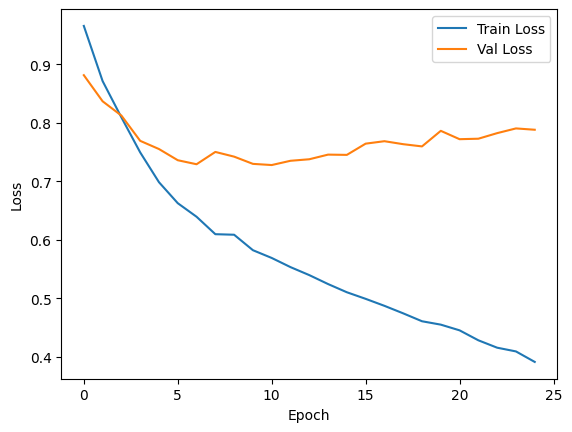

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
modelSeq.evaluate(test_ds)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.8067 - mean_absolute_error: 0.7048 - root_mean_squared_error: 0.8972


[0.7275808453559875, 0.6756570935249329, 0.8529834747314453]

From the configuration of our model, the results of loss shown from the graph indicates that our model overfits. We can see this because the val loss increases over epochs, but our train loss decreases. this indicates that our model is able find patterns and hence able to predict from our training data. However when exposed to our validation data, its loss increases over epochs, meaning our model fails to catch the patterns of new unseen data. This indicates that our model "memorizes" patterns too much in our train data, hence when exposed to unseen patterns, our model fails to perform

## Functional

Next we're going to create a functional model, the difference between this  and the one before is that the first hidden layer is connected to hidden layer 2 and 3, hence branching. This  means that both dense2 and dense3 receive input from dense1, and their layers will then be concatenated

In [ ]:
train_ds

<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 28), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [ ]:
inputs = tf.keras.Input(shape=(28,))

dense1 = Dense(64, activation="relu")(inputs)
dense2 = Dense(32,activation="relu")(dense1)
dense3 = Dense(64, activation="relu")(dense1)

cat_layer = tf.keras.layers.Concatenate(axis=1)([dense3,dense2])

out = Dense(1,activation='linear')(cat_layer)

modelFunc = Model(inputs=inputs, outputs=out)
modelFunc.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 28)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      1,856 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      4,160 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      2,080 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96)        │          0 │ dense_5[0][0],    │
│ (Concatenate)       │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │         97 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,193 (32.00 KB)

 Trainable params: 8,193 (32.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
modelFunc.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
              ,loss=tf.keras.losses.MeanSquaredError()
              ,metrics=[tf.keras.metrics.MeanAbsoluteError(),tf.keras.metrics.RootMeanSquaredError()])

history = modelFunc.fit(train_ds,validation_data=val_ds,epochs = 50 )

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 1.0436 - mean_absolute_error: 0.8320 - root_mean_squared_error: 1.0215 - val_loss: 0.9361 - val_mean_absolute_error: 0.7698 - val_root_mean_squared_error: 0.9675
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8675 - mean_absolute_error: 0.7640 - root_mean_squared_error: 0.9312 - val_loss: 0.8727 - val_mean_absolute_error: 0.7434 - val_root_mean_squared_error: 0.9342
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8689 - mean_absolute_error: 0.7599 - root_mean_squared_error: 0.9313 - val_loss: 0.8215 - val_mean_absolute_error: 0.7224 - val_root_mean_squared_error: 0.9064
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7795 - mean_absolute_error: 0.7065 - root_mean_squared_error: 0.8827 - val_loss: 0.7891 - val_mean_absolute_error: 0.7126 - val_root_mean_squared_error: 0.8883
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6832 - mean_absolute_error: 0.6642 - root_mean_squared_erro

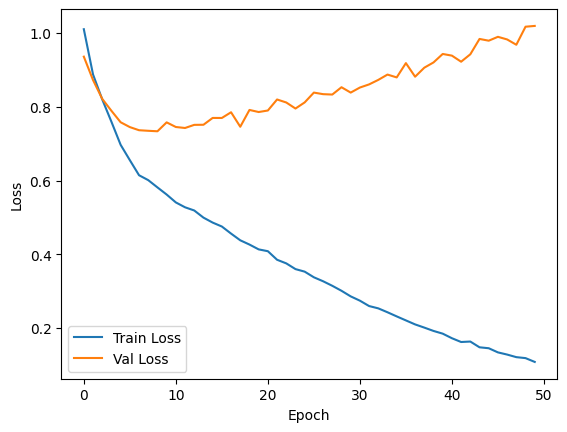

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
modelFunc.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.8287 - mean_absolute_error: 0.7333 - root_mean_squared_error: 0.9100


[0.8143938779830933, 0.7259758710861206, 0.9024377465248108]

From the graph of train and val loss, this model perfomed similarly to the sequential model, where we see the val loss continue to increasse as train loss decreasese. This is an indicator that our model is overfitting

Based off the results of the functional model, it perfomed worse than the sequential model. Looking from the error metrics, this model boasts greater error throughout the board, indicating that the predicted values of this model have greater mean deviations than the tru value..


## Sequential Tuned

For the tuned sequential model, i added batchnormalization regularizers and dropout. These we're added to help tackle the overfitting problem we have.

dropout helps our model not rely too heavily on certain neurons, by having the neurons "dropped" each training step

regularizers will help tackle overfitting by adding loss penalties to larger weights, forcing the model to use more simple and smaller weights, which improves generalization


we will use gridsearch to look for the most optimal combiunation of values for learningrate, regularizer, number of neurons per layer and also apply a earlystop callback function, to stop iterations after val loss stops decreaising

In [69]:
train_ds

<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 28), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [71]:
from tensorflow.keras.layers import BatchNormalization

def model_builder(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=64, step=2),
                    activation='relu', input_shape=(28,),
                    kernel_regularizer=tf.keras.regularizers.l2(hp.Choice('l2_reg', values=[1e-2, 1e-3, 1e-4]))
                   ))
    model.add(BatchNormalization()) # Added BatchNormalization

    model.add(tf.keras.layers.Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=1, step=0.1))) # Added Dropout
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])),
                  loss='mse',
                  metrics=[tf.keras.metrics.MeanAbsoluteError(),tf.keras.metrics.RootMeanSquaredError()])
    return model

# Create a tuner
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=50,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')


stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
# Perform hyperparameter search
tuner.search(x_train, y_train, epochs=50, validation_data=(x_val, y_val), callbacks=[stop_early])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
modelSeqMod = tuner.hypermodel.build(best_hps)

# Train the model
history = modelSeqMod.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val))

# Evaluate the model
modelSeqMod.evaluate(x_test, y_test)

Reloading Tuner from my_dir/intro_to_kt/tuner0.json
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 4.2668 - mean_absolute_error: 1.6052 - root_mean_squared_error: 2.0513 - val_loss: 0.8825 - val_mean_absolute_error: 0.7307 - val_root_mean_squared_error: 0.9374
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2516 - mean_absolute_error: 0.8699 - root_mean_squared_error: 1.1163 - val_loss: 0.8700 - val_mean_absolute_error: 0.7247 - val_root_mean_squared_error: 0.9307
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8430 - mean_absolute_error: 0.7465 - root_mean_squared_error: 0.9153 - val_loss: 0.8699 - val_mean_absolute_error: 0.7224 - val_root_mean_squared_error: 0.9305
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8536 - mean_absolute_error: 0.7353 - root_mean_squared_error: 0.9214 - val_loss: 0.8427 - val_mean_absolute_error: 0.7131 - val_root_mean_squared_error: 0.9158
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8829 - mean_absolute_error: 0.7511 - root_mean_squared_error: 0.9369 -

[0.7332876920700073, 0.6832502484321594, 0.851561963558197]

In [72]:
best_hps.values

{'units': 42,
 'l2_reg': 0.0001,
 'dropout_rate': 0.6,
 'learning_rate': 0.01,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 17,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '0049'}

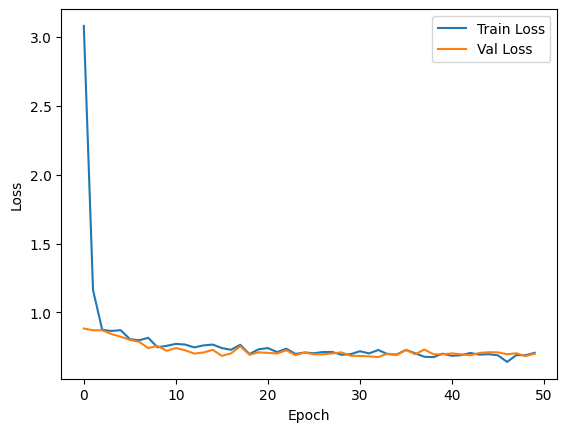

In [73]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [74]:
modelSeqMod.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.8073 - mean_absolute_error: 0.7116 - root_mean_squared_error: 0.8931


[0.7332876920700073, 0.6832502484321594, 0.851561963558197]

From the train and val loss graph above, we can see the both values converge after a certain point, and the values of train and val loss do not differ too much. This inidcates that the model fits just fine (no underfit or overfit)

when runnign the test data into our model, the results prove to be better than the untuned sequential model

## Functional Tuned

Similarly to the tuned sequential model, this functional tuned model will have batchnormalization, regularizers and dropouts at each layer. we'll also perform hyperparameter tuning to find the best values for each of these.

In [75]:
train_ds

<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 28), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [76]:
import keras_tuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Concatenate
from tensorflow.keras import regularizers
import tensorflow as tf

def model_builder(hp):
    inputs = tf.keras.Input(shape=(28,))

    # Tune the number of units in each Dense layer
    units1 = hp.Int('units1', min_value=32, max_value=128, step=16)
    units2 = hp.Int('units2', min_value=32, max_value=128, step=16)
    units3 = hp.Int('units3', min_value=32, max_value=128, step=16)

    #tune L2 regularization strength
    l2_reg = hp.Choice('l2_reg', values=[1e-2, 1e-3, 1e-4])
    reg = regularizers.l2(l2_reg)

    # Tune dropout rate
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)

    dense1 = Dense(units1, activation="relu", kernel_regularizer=reg)(inputs)
    bn1 = BatchNormalization()(dense1)
    drop1 = Dropout(dropout_rate)(bn1)

    dense2 = Dense(units2, activation="relu", kernel_regularizer=reg)(drop1)
    bn2 = BatchNormalization()(dense2)
    drop2 = Dropout(dropout_rate)(bn2)

    dense3 = Dense(units3, activation="relu", kernel_regularizer=reg)(drop1)
    bn3 = BatchNormalization()(dense3)
    drop3 = Dropout(dropout_rate)(bn3)

    cat_layer = Concatenate(axis=1)([drop3, drop2])

    out = Dense(1, activation='linear')(cat_layer)

    model = Model(inputs=inputs, outputs=out)

    # Tune learning rate
    lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='mse',
        metrics=[tf.keras.metrics.MeanAbsoluteError(),tf.keras.metrics.RootMeanSquaredError()]
    )

    return model

tuner = kt.Hyperband(
    model_builder,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='my_dir',
    project_name='functional_model_tuning'
)


early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


tuner.search(x_train, y_train, epochs=50, validation_data=(x_val, y_val), callbacks=[early_stop])

best_hps = tuner.get_best_hyperparameters(1)[0]
modelFuncMod = tuner.hypermodel.build(best_hps)
history = modelFuncMod.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val), callbacks=[early_stop])


Reloading Tuner from my_dir/functional_model_tuning/tuner0.json
Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 194ms/step - loss: 3.9010 - mean_absolute_error: 1.2900 - root_mean_squared_error: 1.6182 - val_loss: 2.1593 - val_mean_absolute_error: 0.7441 - val_root_mean_squared_error: 0.9584
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.2209 - mean_absolute_error: 0.8125 - root_mean_squared_error: 1.0072 - val_loss: 1.9800 - val_mean_absolute_error: 0.7332 - val_root_mean_squared_error: 0.9506
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0100 - mean_absolute_error: 0.8056 - root_mean_squared_error: 0.9886 - val_loss: 1.8092 - val_mean_absolute_error: 0.7449 - val_root_mean_squared_error: 0.9557
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6079 - mean_absolute_error: 0.6754 - root_mean_squared_error: 0.8674 - val_loss: 1.6191 - val_mean_absolute_error: 0.7333 - val_root_mean_squared_error: 0.9393
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - l

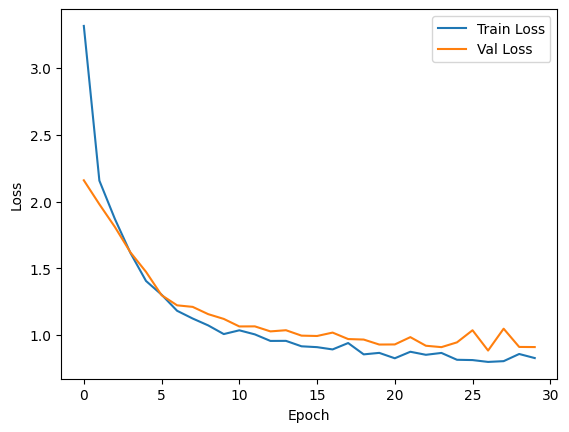

In [77]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [78]:
modelFuncMod.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 1.0233 - mean_absolute_error: 0.7628 - root_mean_squared_error: 0.9259


[0.954674243927002, 0.7194564342498779, 0.889492928981781]

# Evaluation

In [79]:
print(modelSeq.evaluate(test_ds))
print(modelFunc.evaluate(test_ds))
print(modelSeqMod.evaluate(test_ds))
print(modelFuncMod.evaluate(test_ds))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8067 - mean_absolute_error: 0.7048 - root_mean_squared_error: 0.8972
[0.7275808453559875, 0.6756570935249329, 0.8529834747314453]
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8287 - mean_absolute_error: 0.7333 - root_mean_squared_error: 0.9100
[0.8143938779830933, 0.7259758710861206, 0.9024377465248108]
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8073 - mean_absolute_error: 0.7116 - root_mean_squared_error: 0.8931
[0.7332876920700073, 0.6832502484321594, 0.851561963558197]
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0233 - mean_absolute_error: 0.7628 - root_mean_squared_error: 0.9259
[0.954674243927002, 0.7194564342498779, 0.889492928981781]


In [80]:
import numpy as np
from sklearn.metrics import r2_score

y_pred = modelSeq.predict(x_test)
r2 = r2_score(y_test, y_pred)
print("R² score:", r2)

y_pred = modelFunc.predict(x_test)
r2 = r2_score(y_test, y_pred)
print("R² score:", r2)

y_pred = modelSeqMod.predict(x_test)
r2 = r2_score(y_test, y_pred)
print("R² score:", r2)

y_pred = modelFuncMod.predict(x_test)
r2 = r2_score(y_test, y_pred)
print("R² score:", r2)





8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
R² score: 0.2930639556402451
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
R² score: 0.20871409320154477
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
R² score: 0.2954182102427918
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
R² score: 0.23125218951335524


The 3 evaluation metrics ill be using to evaluate all 4 models will be mae, rmse and coefficient of determination (r^2).

From the error reuslts, all four models fall between similar ranges, indicating that the predicitve capabilities of each model has a average mean deviation of about 0.7 (of the scaled output)

From the r2 results, all four models achieve relatively similar r2 scores, ranging from approximately 0.23 to 0.30, indicating that they explain only a modest portion of the variance in the target variable. Among them, the best performing model is modeified seq with an r2 of 0.2954, followed closely by seq and func, suggesting that simple, straightforward architectures without excessive regularization may generalize better in this case. The worst performer is modelFuncMod this could be likely due to over-regularization that limits the model's learning capacity.

This suggests that while regularization is useful for preventing overfitting, too much of it can suppress useful learning, especially when the base model isn’t underfitting.

 Overall, the results imply that simpler models are currently more effective for this task.

link to drive with video

https://drive.google.com/drive/folders/1LQmZkn6iLeOvBUK7TGP10uPjMX4CXxUD?usp=drive_link